#### Part1. 기본학습 - AI 핵심이론 및 활용         
    chp06 - 데이터 전처리      

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

df = pd.read_csv('data/Clean_Dataset.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## random하게 결측치 생성하여 인덱스 1,3에 적용 
df_na = df.copy()
for i in range(0,5000): 
    df_na.iloc[random.randint(0,300152), random.randint(0,10)] = np.nan  ## df.shape = (300153, 11)

df_na.iloc[1] = np.nan
df_na.iloc[3] = np.nan

df_na.isnull().sum()

airline             464
flight              453
source_city         465
departure_time      445
stops               465
arrival_time        444
destination_city    469
class               458
duration            434
days_left           452
price               470
dtype: int64

In [2]:
## (결측치가 포함된) 원래의 데이터 따로 저장 
df_na_origin = df_na.copy()

In [3]:
## 1. 결측치 제거 
df_na.dropna().isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [4]:
## 2. 결측치 대체 
df_na = df_na_origin.copy()
df_na.fillna(df_na.select_dtypes(include=['number']).mean()).isnull().sum()  #문자형 변수는 평균을 낼수 없음 유의

#df_na.fillna(method='ffill') ~ 앞의 값으로 대체하기 
#df_na.fillna(method='bfill') ~ 뒤의 값으로 대체하기 

airline             464
flight              453
source_city         465
departure_time      445
stops               465
arrival_time        444
destination_city    469
class               458
duration              0
days_left             0
price                 0
dtype: int64

In [5]:
# 3. 신뢰수준 95%(Z_score +/- 1.96) 범위밖의 데이터 갯수 구하기 
def outlier_counter(df, column): 
    data = df[column]
    mean = data.mean()
    std = data.std()
    z_scores = (data - mean) / std
    outliers = z_scores[(z_scores < -1.96) | (z_scores > 1.96)]
    
    return len(outliers)

df_na = df_na_origin.copy()
print('Outliers of duration = ', outlier_counter(df_na, 'duration'))
print('Outliers of price = ', outlier_counter(df_na, 'price'))

Outliers of duration =  12263
Outliers of price =  12482


In [6]:
# 4. 1Q~3Q 범위의 1.5배 이상이면 outlier로 간주 
def outlier_counter2(df, column): 
    data = df[column]
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1  # IQR 계산
    lower_bound = q1 - 1.5 * iqr  # 하한선
    upper_bound = q3 + 1.5 * iqr  # 상한선
    outliers = df[(data < lower_bound) | (data > upper_bound)]  # 이상치 필터링
    
    return len(outliers)

df_na = df_na_origin.copy()
print('Outliers of duration = ', outlier_counter2(df_na, 'duration'))
print('Outliers of price = ', outlier_counter2(df_na, 'price'))

Outliers of duration =  2106
Outliers of price =  123


<Axes: >

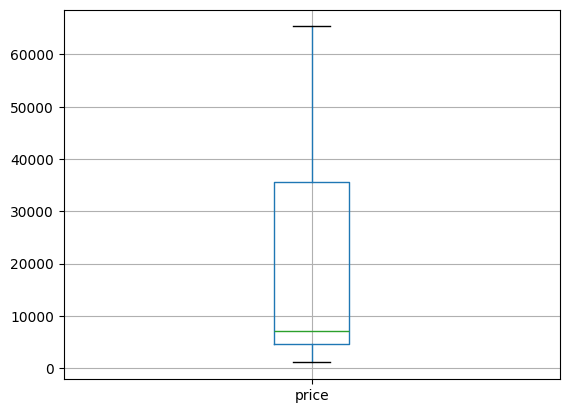

In [ ]:
# 5. 신뢰수준 95% 이외의 값들 제거(95% 범위안의 데이터만 남기기) 
def clean_outlier(df, column): 
    data = df[column]
    mean = data.mean()
    std = data.std()
    z_score = (data-mean)/std 
    df_cleaned = df[(z_score >= -1.96) & (z_score <= 1.96)]
    
    return df_cleaned

df_na = df_na_origin.copy()
df_cleaned = clean_outlier(df_na, 'price')
df_cleaned[['price']].boxplot()
plt.show()

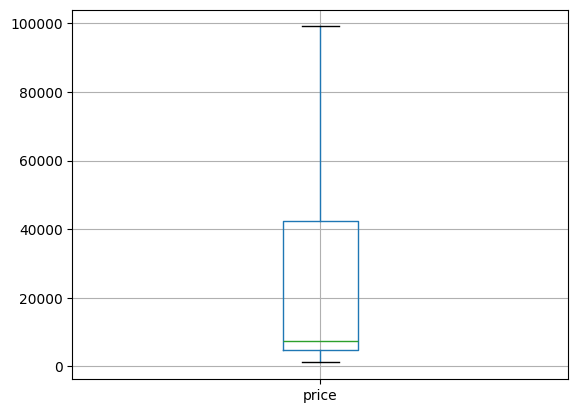

In [16]:
# 6. Q1 ~ Q3 범위밖의 값은 특정값으로 대체
def chang_outlier(df, column): 
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1 - 1.5 * iqr  # 하한선
    upper_bound = q3 + 1.5 * iqr  # 상한선

    df.loc[(df[column] < lower_bound), column] = lower_bound
    df.loc[(df[column] > upper_bound), column] = upper_bound

    return(df)

df_cleaned = chang_outlier(df, 'price')
df_cleaned[['price']].boxplot()
plt.show()  

In [ ]:
# 7. 비행시간을 3구간으로 나누기 (short: 0~5 / medium: 5~10 / long: 10+)
## pd.cut ~ 사용자가 입력한 값에 따라 구간을 나눈다. 
df['distance'] = pd.cut(
                        df['duration'], 
                        bins=[0,5,10, df['duration'].max()], 
                        labels = ['short', 'medium', 'long'] 
                        )

df['distance'].value_counts()

distance
long      169879
medium     84761
short      45513
Name: count, dtype: int64

In [ ]:
# 8. 가격을 동일한 4개 구간으로 나누기 (cheap / normal / expensive / too expensive)
## qcut ~ 사용자가 몇개 구간으로 나눌지를 지정한다. 
df['price_rate'] = pd.qcut(df['price'], 4, 
                           labels = ['cheap', 'normal', 'expensive', 'too expensive']
                           )

df['price_rate'].value_counts()

price_rate
expensive        75584
normal           75117
cheap            75073
too expensive    74379
Name: count, dtype: int64

In [33]:
# 9. 카테고리(문자열) 데이터 인코딩 
df = df_na_origin.copy()
df = df.dropna(subset=['airline'])

df['label_encoding'] = pd.factorize(df['airline'])[0].reshape(-1,1)
## [0] ~ 정수로 인코딩하라 
## reshape(-1, 1) ~ 행은 무제한, 열은 1개 
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,label_encoding
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0,0
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1.0,5956.0,1
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5955.0,2
5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1.0,5955.0,2
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1.0,6060.0,2


In [35]:
# 10. 사이킷런을 사용한 인코딩 
## 참고. pd.foctorize는 변수가 나오는 순서대로, 반면 sklearn은 변수 알파벳 순으로 인코딩함 
df = df_na_origin.copy()
df = df.dropna(subset=['airline'])

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

df['label_encoder'] = le.fit_transform(df['airline'])
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,label_encoder
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0,4
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1.0,5956.0,0
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5955.0,5
5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1.0,5955.0,5
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1.0,6060.0,5


In [41]:
# 11. One-Hot encoding : 1) pandas dummies 
df = df_na_origin.copy()
df = df.dropna(subset=['class'])

df = pd.get_dummies(df, columns = ['class'])
print(df.head(2)) 
print('------------------------------------------------------------------------------------------')
df[['class_Business', 'class_Economy']] = df[['class_Business', 'class_Economy']].astype(int)
print(df.head(2))

    airline   flight source_city departure_time stops   arrival_time  \
0  SpiceJet  SG-8709       Delhi        Evening  zero          Night   
2   AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   

  destination_city  duration  days_left   price  class_Business  class_Economy  
0           Mumbai      2.17        1.0  5953.0           False           True  
2           Mumbai      2.17        1.0  5956.0           False           True  
------------------------------------------------------------------------------------------
    airline   flight source_city departure_time stops   arrival_time  \
0  SpiceJet  SG-8709       Delhi        Evening  zero          Night   
2   AirAsia   I5-764       Delhi  Early_Morning  zero  Early_Morning   

  destination_city  duration  days_left   price  class_Business  class_Economy  
0           Mumbai      2.17        1.0  5953.0               0              1  
2           Mumbai      2.17        1.0  5956.0               0       

In [44]:
# 12. One-Hot encoding : 2) sklearn
df = df_na_origin.copy()
df = df.dropna(subset=['class'])

from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
encoder = oh.fit_transform(df['class'].values.reshape(-1,1)).toarray()

## 인코딩 결과를 df로 만들고, 원본에 붙여넣기
df_onthot = pd.DataFrame(encoder, columns = ['class_' + str(oh.categories_[0][1]) for i in range(len(oh.categories_[0]))])
df1 = pd.concat([df, df_onthot], axis=1)
df1.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,class_Economy,class_Economy
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0,0.0,1.0
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1.0,5956.0,0.0,1.0
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5955.0,0.0,1.0
5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1.0,5955.0,0.0,1.0
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1.0,6060.0,0.0,1.0


            duration      days_left          price
count  299719.000000  299701.000000  299683.000000
mean        0.232468       0.520959       0.162245
std         0.146781       0.282528       0.186120
min         0.000000       0.000000       0.000000
25%         0.122449       0.291667       0.030156
50%         0.212653       0.520833       0.051818
75%         0.313061       0.770833       0.339570
max         1.000000       1.000000       1.000000


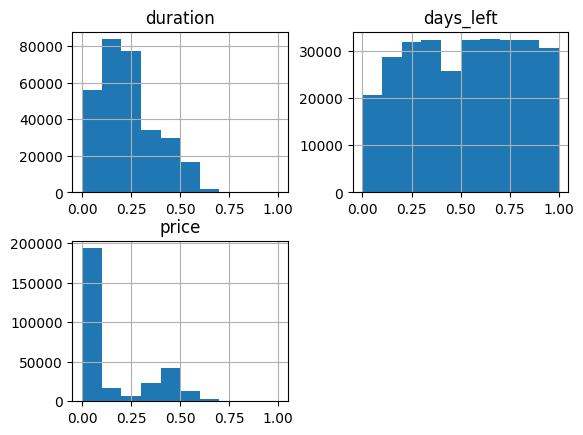

In [56]:
# 13. 정규화 (0~1 사이로 스케일링)
df = df_na_origin.copy()
df_num = df[['duration', 'days_left', 'price']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

print(df_normalized.describe())
df_normalized.hist()
plt.show()

           duration     days_left         price
count  2.997190e+05  2.997010e+05  2.996830e+05
mean  -4.733806e-16 -9.862689e-18  6.069712e-18
std    1.000002e+00  1.000002e+00  1.000002e+00
min   -1.583773e+00 -1.843924e+00 -8.717207e-01
25%   -7.495428e-01 -8.115760e-01 -7.096964e-01
50%   -1.349934e-01 -4.455827e-04 -5.933103e-01
75%    5.490752e-01  8.844240e-01  9.527486e-01
max    5.229105e+00  1.695554e+00  4.501160e+00


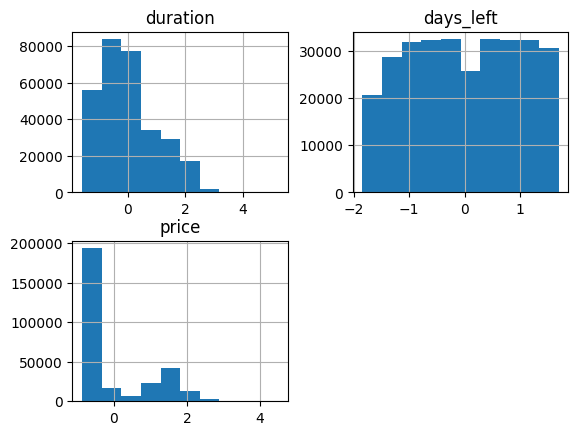

In [57]:
# 14 표준화 (평균 0, 표준편차 1로 스케일링)
df = df_na_origin.copy()
df_num = df[['duration', 'days_left', 'price']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

print(df_standardized.describe())
df_standardized.hist()
plt.show()

In [ ]:
# 15. 항공편 = 제작사 + 모델명 --> 2개 컬럼으로 분리 
def split_flight(flight): 
    manufacture = flight.split('-')[0]
    model_num = flight.split('-')[1]
    return manufacture, model_num 


## 결측치 제거 
df_na = df.dropna(subset=['flight'])

## zip함수와 lambda 사용하여, 제작사와 모델명 컬럼에 값 입력
## 파이썬의 zip() 함수는 여러 iterable(순회 가능한 객체)를 동시에 묶어주는 매우 유용한 내장 함수 ~ zip(*iterables)
df_na['manufacture'], df_na['model_num'] = zip(
                                          *df_na['flight'].apply(lambda x: split_flight(x))
                                          )

df_na.head()

C:\Users\Seoyeon\AppData\Local\Temp\ipykernel_24552\1162332167.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['manufacture'], df_na['model_num'] = zip(
C:\Users\Seoyeon\AppData\Local\Temp\ipykernel_24552\1162332167.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['manufacture'], df_na['model_num'] = zip(


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,manufacture,model_num
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0,SG,8709
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1.0,5956.0,I5,764
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5955.0,UK,963
5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1.0,5955.0,UK,945
6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1.0,6060.0,UK,927


In [88]:
# 16. source_city + destination_city -> route 만들기 
df['route'] = df.apply(
    lambda x: (x['source_city'], x['destination_city']), axis=1 )

df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,route
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0,"(Delhi, Mumbai)"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)"
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1.0,5956.0,"(Delhi, Mumbai)"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(nan, nan)"
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5955.0,"(Delhi, Mumbai)"


##### 확인문제 중 
1. 데이터 손실 최소화를 위해 모든 컬럼이 결측치인 경우에만 변수를 삭제하려면?  --> .dropna(how='all')
2. 결측치를 다른 값으로 대체할 때, 가장 주의할 점은? --> 원래의 분포를 유지하도록 해야한다. 
3. pd.factorize와 sklearn의 LabelEncoder의 차이는? --> 판다스는 변수의 인덱스 순서에 따라, 사이킷런은 변수(카테고리)명의 알파벳 순서로 인코딩
4. One-Hot encoding 결과를 df에 반영하는 명령어는? --> get.dummies()
5. min-max scaling의 수식을 설명하라 --> 관측치와 최소값의 차를 전체 범위로 나눈다. ** X = (Xn - Xmin) / Xmax - Xmin 
6. 표준화의 수식을 설명하라 --> 평균 0, 표준편차 1인 분포로 변환한다. ** X = (Xn - Xmean) / Xstd 